In [241]:
import random
import numpy as np
import os
from dataset import dataset
import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict


In [242]:
def make_plots(f1_scores, loss_scores, names_list):
    f1_data = [f1_scores[i] for i in range(len(f1_scores))]
    loss_data = [loss_scores[i] for i in range(len(loss_scores))]

    positions = np.arange(len(f1_scores))
    width = 0.4

    plt.figure(figsize=(8, 6))
    plt.boxplot(f1_data, positions=positions, widths=width, patch_artist=True,
                boxprops=dict(facecolor='lightblue'), medianprops=dict(color='blue'),
                whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                flierprops=dict(markerfacecolor='blue', marker='o'))
    plt.xticks(positions, names_list)
    plt.xlabel('Datasets')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores Across Datasets')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.boxplot(loss_data, positions=positions, widths=width, patch_artist=True,
                boxprops=dict(facecolor='lightcoral'), medianprops=dict(color='red'),
                whiskerprops=dict(color='red'), capprops=dict(color='red'),
                flierprops=dict(markerfacecolor='red', marker='o'))
    plt.xticks(positions, names_list)
    plt.xlabel('Datasets')
    plt.ylabel('0/1 Loss Score')
    plt.title('0/1 Loss Scores Across Datasets')
    plt.tight_layout()
    plt.show()

In [243]:
class algorithm:
    def __init__(self, data_array:dataset, which_data:str):
        # The algorithm takes in a pre-processed dataset object, there shouldn't be much to do with the constructor except maybe a setter for the dataset
        self.data_array = data_array

        # Determines label type
        cancer_labels = ['2','4']
        glass_labels = ['1','2','3','4','5','6','7']
        iris_labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
        soybean_labels = ['D1','D2','D3','D4']
        votes_labels = ['republican','democrat']
        if (which_data == 'cancer'):
            self.labels = cancer_labels
        elif (which_data == 'glass'):
            self.labels = glass_labels
        elif (which_data == 'iris'):
            self.labels = iris_labels
        elif (which_data == 'soybean'):
            self.labels = soybean_labels
        elif (which_data == 'votes'):
            self.labels = votes_labels

    def train(self):
        # Runs Q(), Runs F().

        # Q() calculates the class prior probabilities.
        self.all_class_counts = []
        self.class_counts = [0] * len(self.labels)
        self.probs = [0] * len(self.labels)
        self.example_count = 0
        self.class_probs = []

        # Perform 10-fold cross-validation
        for i in range(10):
            # Rotate the data for the current fold
            self.rotated_data = self.data_array.partitions[i:] + self.data_array.partitions[:i]
            self.rotated_data = self.rotated_data[:-1]
            self.class_counts = [0] * len(self.labels)  # Reset class counts for the new fold
            self.example_count = 0  # Reset example count for the new fold

            # Count examples for each class
            for partition in range(9):  # Use 9 partitions for training
                for example in range(len(self.rotated_data[partition])):
                    self.example_count += 1  # Total examples count
                    for label in range(len(self.labels)):
                        if self.rotated_data[partition][example][-1] == self.labels[label]:
                            self.class_counts[label] += 1  # Count examples per class

            # Calculate class prior probabilities
            for i, count in enumerate(self.class_counts):
                self.probs[i] = count / self.example_count  # P(Class)
            self.class_probs.append(self.probs.copy())  # Store the probabilities for this fold
            self.all_class_counts.append(self.class_counts.copy())  # Store the class counts for this fold

        # F() calculates the individual attribute probabilities for each class.
        d = self.data_array.attribute_count - 1  # Number of attributes (excluding label)

        # Store attribute value counts for each fold
        self.attribute_value_counts_per_fold = []

        # Perform 10-fold cross-validation
        for i in range(10):
            # Initialize a dictionary for each attribute to count occurrences for the current fold
            attribute_value_counts = [{} for _ in range(d)]
            self.rotated_data = self.data_array.partitions[i:] + self.data_array.partitions[:i]
            self.rotated_data = self.rotated_data[:-1]

            # Count attribute value occurrences per class
            for partition in self.rotated_data:
                for example in partition:
                    for a in range(d):  # Loop over attributes (exclude label index)
                        attr_value = example[a]
                        if attr_value not in attribute_value_counts[a]:
                            attribute_value_counts[a][attr_value] = 0
                        attribute_value_counts[a][attr_value] += 1  # Increment count for this attribute value
            
            # Store attribute value counts for this fold
            self.attribute_value_counts_per_fold.append(attribute_value_counts)

        # Now calculate the attribute probabilities
        self.attribute_probs = []
        for i in range(10):
            self.attribute_probs.append([])  # Create a list for each fold
            for classs in range(len(self.all_class_counts[i])):  # Loop over each class
                self.attribute_probs[i].append([])  # Create a list for each class
                for attribute in range(d):  # Loop over each attribute
                    self.attribute_probs[i][classs].append({})
                    keys = list(self.attribute_value_counts_per_fold[i][attribute].keys())
                    for key in keys:
                        # Ensure that the numerator comes from correct class counts
                        numerator = self.attribute_value_counts_per_fold[i][attribute].get(key, 0)
                        N = self.all_class_counts[i][classs]  # Number of examples in the class
                        probability_value = (numerator + 1) / (N + len(keys))  # Laplace Smoothing applied
                        self.attribute_probs[i][classs][attribute][key] = probability_value  # Store the probability

        # Optional: Debugging print statements to verify attribute counts and probabilities
        '''
        for fold, counts in enumerate(self.attribute_value_counts_per_fold):
            print(f"Fold {fold+1}:")
            for attribute_index, count_dict in enumerate(counts):
                print(f"  Attribute {attribute_index}: {count_dict}")
        for fold, probs in enumerate(self.attribute_probs):
            print(f"Fold {fold+1}:")
            for classs, attributes in enumerate(probs):
                print(f"  Class {classs}:")
                for attribute, values in enumerate(attributes):
                    print(f"    Attribute {attribute}: {values}")
        '''


        print(f"Number of attribute possibilities: {len(self.attribute_value_counts_per_fold[0][0])} Actual Dimension: {len(self.attribute_probs[0][0][0])}")
        print(f"Number of attributes: {len(self.attribute_value_counts_per_fold[0])} Actual Dimension: {len(self.attribute_probs[0][0])}")
        print(f"Number of classes: {len(self.all_class_counts[0])} Actual Dimension: {len(self.attribute_probs[0])}")
        print(f"Number of folds: 10 Actual Dimension: {len(self.attribute_probs)}")

        # Once everything is run we should have trained 10 models for this method call. We will probably want to store each of these models in an array containing the other 2 arrays produced from Q and F, meaning there will be a ~7D array :/
        # We will also want to save each of the models for both validation purposes, and for the event processing fails downstream we won't have to re-train
        

        
        return
    
    '''
        d = self.data_array.attribute_count-1
        # This list will end up having dimensions # of models * # of attributes: each indice contains the # of examples that have the attribute
        self.attribute_values = [[] for _ in range(d)]
        self.example_matches = [[0 for _ in range (d)] for _ in range(10)]
        #print(f'SELF.EXAMPLE MATCHES: {self.example_matches}')
        
        # Produces a list of all of the possible attribute values in the dataset
        for partition in range(len(self.data_array.partitions)):
            for example in range(len(self.data_array.partitions[partition])):
                for a, attribute in enumerate(self.data_array.partitions[partition][example][:-1]):
                    if attribute not in self.attribute_values[a]:
                        self.attribute_values[a].append(attribute)
        #print(f"Self.attribute_values: {self.attribute_values}")

        for i in range(10):
            self.rotated_data = self.data_array.partitions[i:] + self.data_array.partitions[:i]
            self.rotated_data = self.rotated_data[:-1]
            for partition in range(9):
                for example in range(len(self.rotated_data[partition])):
                    for attribute in range(d):
                        if (self.rotated_data[partition][example][attribute] in self.attribute_values[attribute]):
                            self.example_matches[i][attribute] += 1

                        
                        for value in self.attribute_values[attribute]:
                            # Every time we enter this if statement we want to count if the attribute value has been repeated for the example
                            if (self.rotated_data[partition][example][attribute] == value):
                                self.example_matches[i][attribute] += 1
                        
            
            for i, count in enumerate(self.class_counts):
                self.probs[i] = count/(self.example_count)
            self.class_probs.append(self.probs.copy())
            
        '''
    


        
    def validate(self):
        # This method runs the algorithm on the validation folds. We want to make sure we are running the proper model on the proper fold, so if you trained on folds 1-9, you would start the for loop at 10 and decrement (for example).
        # This will produce 10 classified folds, where we will want to save the results from the classification.

        fold_order = [9] + list(range(0, 9))  #sets the order for which partition is our validation set
        self.answers = []
        self.predictions = []
        for i in range(10):  #goes through each model
            test_fold_index = fold_order[i]
            class_prob_index = fold_order[(i + 1) % 10]

        
            test_fold = self.data_array.partitions[test_fold_index]
            attribute_probs = self.attribute_probs[class_prob_index]
            
            self.correct_preditions = 0
            total_predictions = len(test_fold)

            for example in test_fold:
                features = example[:-1]
                true_label = example[-1]
                self.answers.append(true_label)
                max_class_prob = -float('inf')
                predicted_class = None


                for classs in range(len(self.all_class_counts[class_prob_index])):
                    class_prob = self.class_probs[class_prob_index][classs]

                    for feature_index, feature_value in enumerate(features):
                        '''
                        print(f"i: {i}")
                        print(f"classs: {classs}")
                        print(f"featire index: {feature_index}")
                        print(f"Feature Value: {feature_value}")
                        print(f"Feature Value: {type(feature_value)}")
                        print(f"Attribute probability keys: {type(attribute_probs[i][classs])}")
                        '''
                        feature_prob = attribute_probs[classs][feature_index].get(feature_value)
                        #print(feature_value, type(feature_prob))
                        #print(type(feature_prob))
                        if(feature_prob is None):
                            class_prob *= 1
                            #print(type(feature_prob))
                        else:
                            class_prob *= feature_prob


                    if class_prob > max_class_prob:
                        max_class_prob = class_prob
                        predicted_class = self.labels[classs]

                predicted_label = predicted_class
                self.predictions.append(predicted_label)
    def calculate_loss(self):
        # This method will analyze the classification, and determine, TP, TN, FP, FN, F1 loss, 0/1 loss, etc.
        # These results need to be saved
        # We will also want to create a box plot where the x-axis is the dataset we worked with (10 datasets), and y axis is a performance metric (whatever we want). For each dataset there will be 10 datapoints in the box, each point represents the performance of one of the folds.
        self.zero_one_losses = []
        self.f1_scores = []
        fold_order = [9] + list(range(0, 9))
        for fold_index in fold_order:
            test_fold = self.data_array.partitions[fold_index]

            true_positives = {label: 0 for label in self.labels}
            false_positives = {label: 0 for label in self.labels}
            false_negatives = {label: 0 for label in self.labels}
            correct_predictions = 0
            total_predictions = len(test_fold)


            for i in range(total_predictions):
                true_label = self.answers[i]
                predicted_label = self.predictions[i]


                if predicted_label == true_label:
                    correct_predictions += 1

                if predicted_label == true_label:
                    true_positives[true_label] += 1
                else:
                    false_positives[predicted_label] += 1
                    false_negatives[true_label] += 1
                
            #loss = (correct_predictions / total_predictions)
            loss = 1 - (correct_predictions / total_predictions)
            self.zero_one_losses.append(loss)



            f1_scores_per_class = []
            for label in self.labels:
                precision = true_positives[label] / (true_positives[label] + false_positives[label]) if (true_positives[label] + false_positives[label]) > 0 else 0
                recall = true_positives[label] / (true_positives[label] + false_negatives[label]) if (true_positives[label] + false_negatives[label]) > 0 else 0
                f1 = ((2 * (precision * recall)) / (precision + recall)) if (precision + recall) > 0 else 0
                f1_scores_per_class.append(f1)
            
            average_f1 = sum(f1_scores_per_class) / len(self.labels)
            self.f1_scores.append(average_f1)


In [244]:
cancer_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/cancer_nopre.csv', 'last', True)
glass_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/glass_nopre.csv', 'last', True)
glass_nopre.discretize(10, True)
votes_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/votes_nopre.csv', 'first', True)
iris_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/iris_nopre.csv', 'last', True)
iris_nopre.discretize(10, False)
soybean_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/soybean_nopre.csv', 'last', True)

cancer_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/cancer_pre.csv', 'last', True)
glass_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/glass_pre.csv', 'last', True)
votes_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/votes_pre.csv', 'first', True)
iris_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/iris_pre.csv', 'last', True)
soybean_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/soybean_pre.csv', 'last', True)

In [245]:
cancer_nopre_processing = algorithm(cancer_nopre, 'cancer')
glass_nopre_processing = algorithm(glass_nopre, 'glass')
votes_nopre_processing = algorithm(votes_nopre, 'votes')
iris_nopre_processing = algorithm(iris_nopre, 'iris')
soybean_nopre_processing = algorithm(soybean_nopre, 'soybean')

cancer_pre_processing = algorithm(cancer_pre, 'cancer')
glass_pre_processing = algorithm(glass_pre, 'glass')
votes_pre_processing = algorithm(votes_pre, 'votes')
iris_pre_processing = algorithm(iris_pre, 'iris')
soybean_pre_processing = algorithm(soybean_pre, 'soybean')

In [246]:
cancer_nopre_processing.train()
glass_nopre_processing.train()
votes_nopre_processing.train()
iris_nopre_processing.train()
soybean_nopre_processing.train()

cancer_pre_processing.train()
glass_pre_processing.train()
votes_pre_processing.train()
iris_pre_processing.train()
soybean_pre_processing.train()

Number of attribute possibilities: 10 Actual Dimension: 10
Number of attributes: 9 Actual Dimension: 9
Number of classes: 2 Actual Dimension: 2
Number of folds: 10 Actual Dimension: 10
Number of attribute possibilities: 9 Actual Dimension: 9
Number of attributes: 9 Actual Dimension: 9
Number of classes: 7 Actual Dimension: 7
Number of folds: 10 Actual Dimension: 10
Number of attribute possibilities: 2 Actual Dimension: 2
Number of attributes: 16 Actual Dimension: 16
Number of classes: 2 Actual Dimension: 2
Number of folds: 10 Actual Dimension: 10
Number of attribute possibilities: 4 Actual Dimension: 4
Number of attributes: 4 Actual Dimension: 4
Number of classes: 3 Actual Dimension: 3
Number of folds: 10 Actual Dimension: 10
Number of attribute possibilities: 7 Actual Dimension: 7
Number of attributes: 35 Actual Dimension: 35
Number of classes: 4 Actual Dimension: 4
Number of folds: 10 Actual Dimension: 10
Number of attribute possibilities: 10 Actual Dimension: 10
Number of attributes

In [247]:
cancer_nopre_processing.validate()
print(f"Attribute_value_counts_per_fold: {glass_nopre_processing.attribute_value_counts_per_fold}")
print(f"Attribute_probs: {glass_nopre_processing.attribute_probs}")
glass_nopre_processing.validate()
votes_nopre_processing.validate()
iris_nopre_processing.validate()
soybean_nopre_processing.validate()

cancer_pre_processing.validate()
glass_pre_processing.validate()
votes_pre_processing.validate()
iris_pre_processing.validate()
soybean_pre_processing.validate()

Attribute_value_counts_per_fold: [[{'3': 42, '2': 97, '4': 26, '1': 11, '7': 3, '6': 3, '5': 6, '0': 4, '8': 1}, {'3': 85, '5': 24, '2': 13, '4': 52, '6': 12, '0': 3, '1': 3, '9': 1}, {'8': 59, '7': 75, '6': 15, '0': 39, '5': 4, '4': 1}, {'8': 74, '4': 27, '5': 72, '0': 8, '6': 6, '7': 5, '3': 1}, {'4': 35, '5': 87, '6': 30, '2': 5, '3': 24, '1': 3, '7': 2, '0': 3, '75': 1, '8': 2, '9': 1}, {'0': 156, '1': 31, '9': 4, '6': 2}, {'2': 92, '3': 62, '4': 15, '0': 3, '8': 3, '7': 3, '5': 9, '6': 1, '1': 5}, {'0': 168, '9': 8, '4': 4, '6': 8, '5': 4, '3': 1}, {'0': 132, '3': 14, '1': 15, '5': 6, '2': 12, '4': 10, '7': 1, '6': 3}], [{'2': 100, '4': 24, '6': 3, '3': 39, '1': 11, '5': 7, '0': 5, '7': 2, '8': 1}, {'2': 18, '3': 79, '4': 52, '5': 22, '6': 13, '1': 3, '9': 1, '0': 3, '7': 1}, {'7': 78, '8': 56, '0': 40, '6': 13, '5': 4, '4': 1}, {'8': 78, '5': 69, '4': 25, '6': 7, '7': 5, '0': 7, '3': 1}, {'5': 85, '2': 5, '3': 24, '6': 33, '4': 30, '1': 4, '7': 3, '0': 4, '75': 1, '8': 2, '9': 1}

In [248]:
cancer_nopre_processing.calculate_loss()
glass_nopre_processing.calculate_loss()
votes_nopre_processing.calculate_loss()
iris_nopre_processing.calculate_loss()
soybean_nopre_processing.calculate_loss()

cancer_pre_processing.calculate_loss()
glass_pre_processing.calculate_loss()
votes_pre_processing.calculate_loss()
iris_pre_processing.calculate_loss()
soybean_pre_processing.calculate_loss()

In [249]:
zero_one_list = [cancer_nopre_processing.zero_one_losses, cancer_pre_processing.zero_one_losses, votes_nopre_processing.zero_one_losses, votes_pre_processing.zero_one_losses, soybean_nopre_processing.zero_one_losses, soybean_pre_processing.zero_one_losses]
f1_scores_list = [cancer_nopre_processing.f1_scores, cancer_pre_processing.f1_scores, votes_nopre_processing.f1_scores, votes_pre_processing.f1_scores, soybean_nopre_processing.f1_scores, soybean_pre_processing.f1_scores]
names_list = ['','','','','','']
#make_plots(zero_one_list, f1_scores_list, names_list)

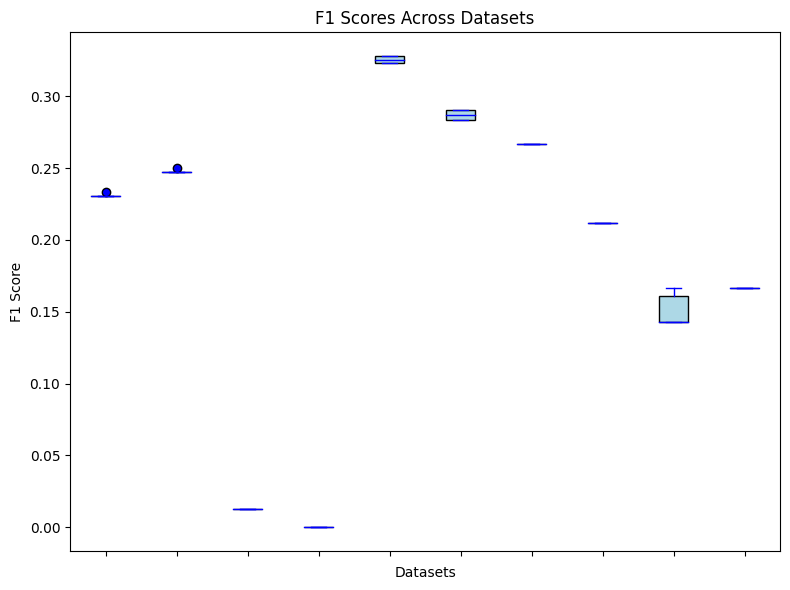

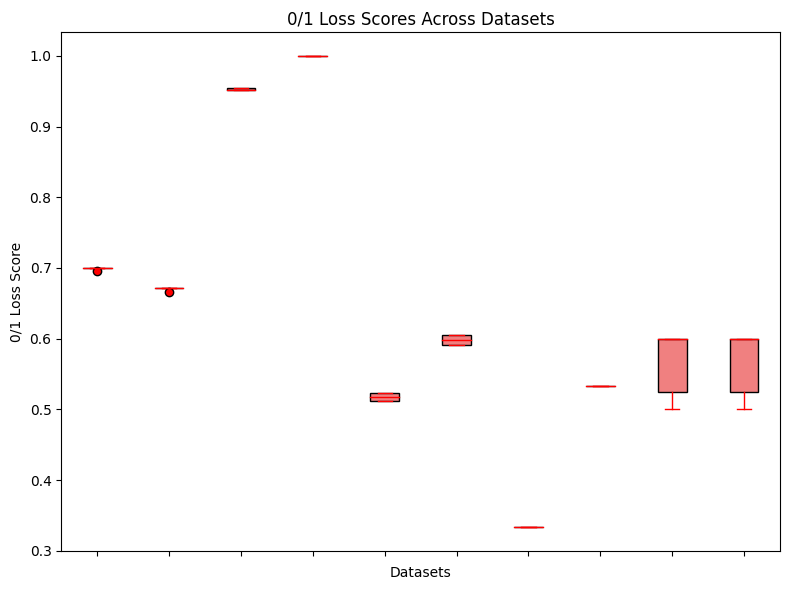

In [250]:
zero_one_list = [cancer_nopre_processing.zero_one_losses, cancer_pre_processing.zero_one_losses, glass_nopre_processing.zero_one_losses, glass_pre_processing.zero_one_losses, votes_nopre_processing.zero_one_losses, votes_pre_processing.zero_one_losses, iris_nopre_processing.zero_one_losses, iris_pre_processing.zero_one_losses, soybean_nopre_processing.zero_one_losses, soybean_pre_processing.zero_one_losses]
f1_scores_list = [cancer_nopre_processing.f1_scores, cancer_pre_processing.f1_scores, glass_nopre_processing.f1_scores, glass_pre_processing.f1_scores, votes_nopre_processing.f1_scores, votes_pre_processing.f1_scores, iris_nopre_processing.f1_scores, iris_pre_processing.f1_scores, soybean_nopre_processing.f1_scores, soybean_pre_processing.f1_scores]
names_list = ['','','','','','','','','','']
make_plots(f1_scores_list, zero_one_list, names_list)

In [251]:
my_list = [1,2,3,4,5,6,7,8,9,10]
for i in range(len(my_list)):
    rotated_list = my_list[i:] + my_list[:i]
    rotated_list = rotated_list[:-1]
    print(rotated_list)
    

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[2, 3, 4, 5, 6, 7, 8, 9, 10]
[3, 4, 5, 6, 7, 8, 9, 10, 1]
[4, 5, 6, 7, 8, 9, 10, 1, 2]
[5, 6, 7, 8, 9, 10, 1, 2, 3]
[6, 7, 8, 9, 10, 1, 2, 3, 4]
[7, 8, 9, 10, 1, 2, 3, 4, 5]
[8, 9, 10, 1, 2, 3, 4, 5, 6]
[9, 10, 1, 2, 3, 4, 5, 6, 7]
[10, 1, 2, 3, 4, 5, 6, 7, 8]
